In [1]:
#!/usr/bin/env python
# coding: utf-8


# -*- coding: utf-8 -*-
import os

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import keras
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Optimizer
from keras import callbacks
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional,concatenate
from keras.models import Model
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from keras.optimizers import Adam
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

np.random.seed(17)


import sys
import csv
from sklearn.ensemble import GradientBoostingClassifier
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from csv import DictReader
from csv import DictWriter
import codecs

from utils.system import parse_params, check_version

Using TensorFlow backend.


# Load data

In [3]:
#load data

train_bodies = pd.read_csv('./fnc-1/train_bodies.csv')
    
train_stances = pd.read_csv('./fnc-1/train_stances.csv')

test_bodies = pd.read_csv('./fnc-1/competition_test_bodies.csv')

test_stances = pd.read_csv('./fnc-1/competition_test_stances.csv')

# Handle the stance coloumn and merge by body id

In [4]:

train_stances['Stance'].replace('agree',0,True)
train_stances['Stance'].replace('disagree',1,True)
train_stances['Stance'].replace('discuss',2,True)
train_stances['Stance'].replace('unrelated',3,True)
train_merge = pd.merge(train_stances, train_bodies, on='Body ID')




test_stances['Stance'].replace('agree',0,True)
test_stances['Stance'].replace('disagree',1,True)
test_stances['Stance'].replace('discuss',2,True)
test_stances['Stance'].replace('unrelated',3,True)

test_merge = pd.merge(test_stances, test_bodies, on='Body ID')
#train_merge.head(10)
test_merge.head(10)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,3,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,2008,3,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,2008,3,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,2008,3,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,2008,2,A RESPECTED senior French police officer inves...
5,Ferguson protester shot in the eye with rubber...,2008,3,A RESPECTED senior French police officer inves...
6,Pregnant Ferguson woman loses her EYE after po...,2008,3,A RESPECTED senior French police officer inves...
7,Pregnant woman loses eye after Ferguson cops f...,2008,3,A RESPECTED senior French police officer inves...
8,Police officer in Charlie Hebdo investigation ...,2008,2,A RESPECTED senior French police officer inves...
9,Pregnant Woman Loses Eye During Ferguson Riots...,2008,3,A RESPECTED senior French police officer inves...


In [5]:
MAX_SENT_LEN = 16
MAX_VOCAB_SIZE = 50000
LSTM_DIM = 100
EMBEDDING_DIM = 50
BATCH_SIZE = 128
N_EPOCHS = 1
MAX_SENT_LEN1 = 100
MAX_VOCAB_SIZE1 = 50000


train_merge['Headline'].head(10)

test_merge['Headline'] = test_merge['Headline'].apply(lambda x: str(x))
train_merge['Headline'] = train_merge['Headline'].apply(lambda x: str(x))

test_merge['articleBody'] = test_merge['articleBody'].apply(lambda x: str(x))
train_merge['articleBody'] = train_merge['articleBody'].apply(lambda x: str(x))


train_merge = train_merge.sample(frac=1, random_state=10)


word_seq_train_stances = [text_to_word_sequence(head) for head in train_merge['Headline']]
word_seq_train_bodies = [text_to_word_sequence(body) for body in train_merge['articleBody']]



word_seq_test_stances = [text_to_word_sequence(head) for head in test_merge['Headline']]
word_seq_test_bodies = [text_to_word_sequence(body) for body in test_merge['articleBody']]

# Create a list for embedding

In [6]:
word_seq = []

for i in range(len(word_seq_train_stances)):
    word_seq.append(word_seq_train_stances[i])
for i in range(len(word_seq_train_bodies)):
    word_seq.append(word_seq_train_bodies[i])


for i in range(len(word_seq_test_stances)):
    word_seq.append(word_seq_test_stances[i])
for i in range(len(word_seq_test_bodies)):
    word_seq.append(word_seq_test_bodies[i])

In [8]:

print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_stances], 75))
print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_bodies], 75))


75th Percentile Sentence Length: 13.0
75th Percentile Sentence Length: 500.0


# pass the words through tokenizer

In [9]:

filter_list = '\r\t\n'
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
print("Number of words in vocabulary:", len(tokenizer.word_index))

tokenizer.word_index

X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train_stances])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')


Number of words in vocabulary: 37466


In [10]:


tokenizer.word_index

X1 = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_train_bodies])
X1 = pad_sequences(X1, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [11]:


X_test_bodies = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_test_bodies])
X_test_bodies = pad_sequences(X_test_bodies, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [12]:


X_test_stances = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test_stances])
X_test_stances = pad_sequences(X_test_stances, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

# Split train and validation data

In [13]:
y = train_merge['Stance']

encoder_train = LabelEncoder()
encoder_train.fit(y)
encoded_train = encoder_train.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

y_test = test_merge['Stance']



train_size =math.ceil( X.shape[0] * 0.9)
train_size_end =math.ceil( X.shape[0] * 0.2)

X_train = X[0:train_size]
X1_train = X1[0:train_size]

X_val = X[train_size:]
X1_val = X1[train_size:]

y_train = dummy_y_train[0:train_size]
y_val = dummy_y_train[train_size:]

print(X_train.shape)
print(X1_train.shape)
print(y_train.shape)

print(X_val.shape)
print(X1_val.shape)
print(y_val.shape)

(44975, 16)
(44975, 100)
(44975, 4)
(4997, 16)
(4997, 100)
(4997, 4)


# import Glove

In [14]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = 'd:/641/glove.twitter.27B.50d.txt'
word2vec_output_file = 'glove.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)



D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1193514, 50)

In [15]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

# Generate conditional encoder layers

In [31]:
headline_embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], 
                          input_length=MAX_SENT_LEN,
                          trainable=False, name='word_embedding_layer', #False
                          mask_zero=True)

article_embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          input_length=MAX_SENT_LEN1,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer1', #False
                          mask_zero=True)



headline_input = Input(shape=(MAX_SENT_LEN,))
embedded_headline = headline_embedding_layer(headline_input)
headline_lstm = LSTM(LSTM_DIM, recurrent_dropout = 0.2, return_sequences = True, return_state = True)
headline_outputs, state_h, state_c = headline_lstm(embedded_headline)

encoder_states = [state_h, state_c]


body_input = Input(shape=(MAX_SENT_LEN1,))
embedded_body = article_embedding_layer(body_input)
article_lstm = LSTM(LSTM_DIM, return_sequences = True)
encoded_article = article_lstm(embedded_body,initial_state=encoder_states)


# implementation of attetion layer

In [32]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
class Attention(Layer):
    def __init__(self, step_dim = 116,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
        


# add attention layer and dense layers

In [33]:
AttentionLayer = Attention()
concatedInput = keras.layers.Concatenate(axis=1)([headline_outputs, encoded_article])
attention_output = AttentionLayer(concatedInput)
x = Dense(50 )(attention_output)
dropout = Dropout(.2)(x)
preds = Dense(4, activation='softmax')(dropout)

(None, 116, 100)


In [34]:
from keras import optimizers
model = Model(inputs=[ headline_input,body_input], outputs=preds)
optimizer = optimizers.Adam(lr=0.001) # 
#add regularize
model.compile(optimizer = optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy' ])

filepath="Mask_Condition_Attention__epoch40_lr0.001_trainable_15Atlength_75_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list = [checkpoint]




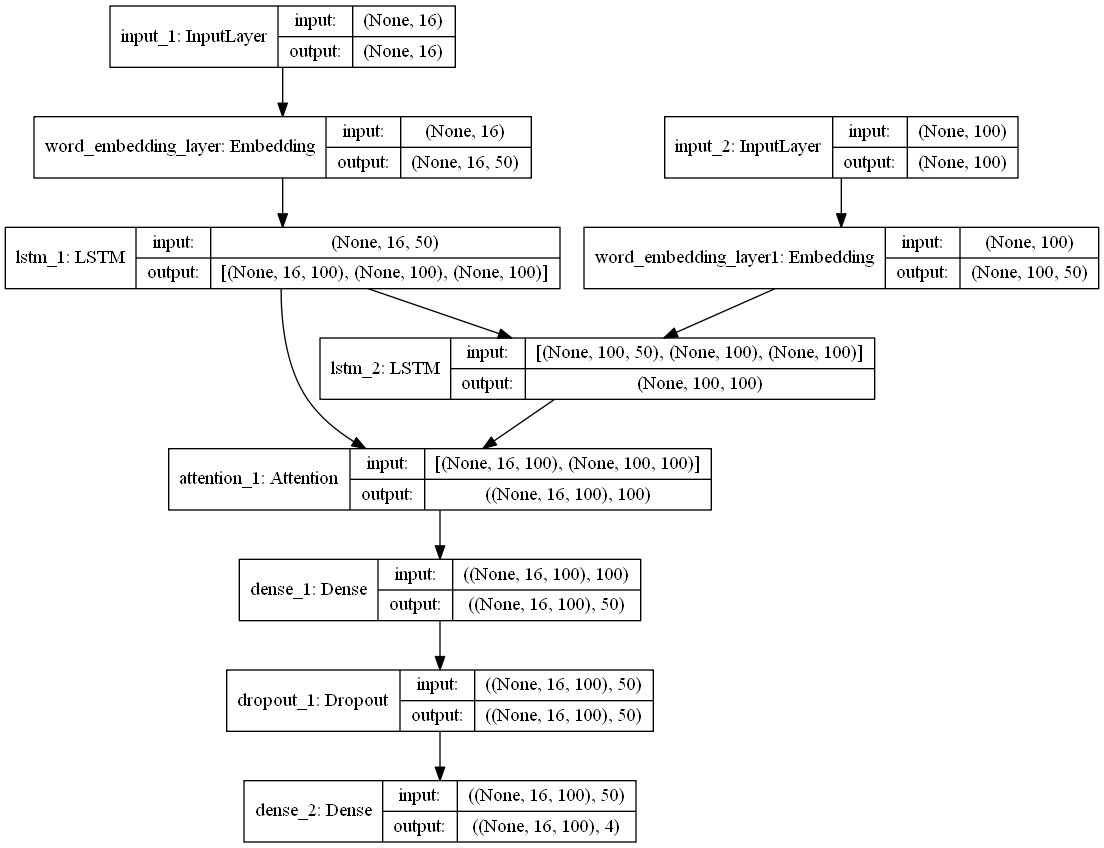

In [35]:
plot_model(model, to_file='models/condition_attention_model.png', show_layer_names=True, show_shapes=True)
Image('condition_attention_model.png')

# Train model

In [ ]:
history = model.fit(
    [X_train, X1_train], y_train,
    validation_data=([X_val, X1_val], y_val),
    epochs=40, batch_size=BATCH_SIZE ,verbose = 1,callbacks = callbacks_list)

# plot for accuracy and loss

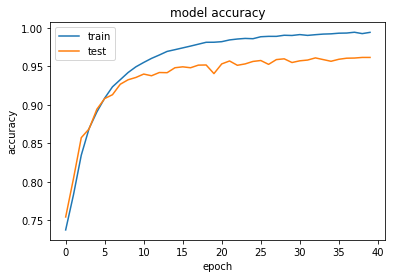

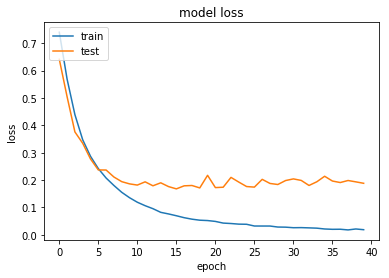

In [27]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# weighted score

In [37]:
predicted = [LABELS[int(np.argmax(a, axis = -1))] for a in model.predict([X_test_stances,X_test_bodies])]

actual = [LABELS[int(a)] for a in y_test]

report_score(actual,predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    703    |    33     |    365    |    802    |
-------------------------------------------------------------
| disagree  |    196    |    25     |    102    |    374    |
-------------------------------------------------------------
|  discuss  |    689    |    39     |   2052    |   1684    |
-------------------------------------------------------------
| unrelated |   1094    |    42     |   1450    |   15763   |
-------------------------------------------------------------
Score: 7076.75 out of 11651.25	(60.73811822765798%)


60.73811822765798

In [99]:
competition_dataset = DataSet("competition_test")
stance_list = predicted

df = pd.DataFrame(data ={'Headline': headline_list, 'Body ID':body_list, 'Stance':predicted})   
df.to_csv('submission.csv', index=False, encoding='utf-8')

Reading dataset
Total stances: 25413
Total bodies: 904


In [26]:
b = test_stances['Body ID']
h = test_stances['Headline']
test = pd.DataFrame(data={'Headline': h, "Body ID": b, 'Stance': predicted})
np.save("b", b)
np.save("h", h)
np.save("predicted", predicted)
test.to_csv("submission.csv", index=False, encoding="utf-8")